### This is the code to fit, predict and forecast using the best GRU model
#### References:
- Peixeiro, M. (2022). Time series forecasting in Python. Manning. Includes the codes fromi its GitHub repo (https://github.com/marcopeix/AppliedTimeSeriesForecastingInPython).   
Contribution: The technique for converting the series into sequenced samples and the idea for scale and reeschale data after predictions.
- Discolll, N. (2024, January 12). Harnessing RNNs for Financial Time Series Analysis: A Python Approach. Medium. https://medium.com/@redeaddiscolll/harnessing-rnns-for-financial-time-series-analysis-a-python-approach-0669b3a25c7a.   
Contribution: EarlyStopping function.
- Cerliani, M. (2021, April 15). Feature Importance with Time Series and Recurrent Neural Network. Medium. https://towardsdatascience.com/feature-importance-with-time-series-and-recurrent-neural-network-27346d500b9c and https://github.com/cerlymarco/MEDIUM_NoteBook/tree/master/NeuralNetSeq_FeatureImportance.  
Contribution: Feature importance function.

#### Libraries
- Package Pandas (2.2). (2024). [Python]. https://pandas.pydata.org/
- Package NumPy (1.23). (2023). [Pyhton]. https://numpy.org/ - Harris, C. R., Millman, K. J., Van Der Walt, S. J., Gommers, R., Virtanen, P., Cournapeau, D., Wieser, E., Taylor, J., Berg, S., Smith, N. J., Kern, R., Picus, M., Hoyer, S., Van Kerkwijk, M. H., Brett, M., Haldane, A., Del Río, J. F., Wiebe, M., Peterson, P., … Oliphant, T. E. (2020). Array programming with NumPy. Nature, 585(7825), 357–362. https://doi.org/10.1038/s41586-020-2649-2
- Droettboom, J. D. H., Michael. (2024). Package matplotlib (3.8.4) [Python]. https://matplotlib.org
- Package scikit-learn (1.4). (2024). [Pyhton]. https://scikit-learn.org/stable/index.html
- Package Tensorflow (2.16). (2024). [Python]. https://github.com/tensorflow

In [8]:
# Import libraries
import random as python_random
from datetime import timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (mean_absolute_error,
                             mean_absolute_percentage_error,
                             mean_squared_error)
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
from tensorflow.keras.models import Sequential  # , load_model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l1_l2
from tensorflow.random import set_seed
import tensorflow as tf

import useful_functions as uf

In [9]:
# load the data
#file_path = '../data/data_orig_parameters.csv'
#file_path = '../data/data_cleaned_RF.csv'
file_path = '../data/data_cleaned_LASSO.csv'
#file_path = '../data/data_cleaned_RFE.csv'

# parse the date column and set it as the index of the dataframe
df_raw = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')

# define the target variable as the first column
target_variable = df_raw.columns[0]

# Convert all columns to float
df_raw = df_raw.astype('float64')

# Define thresholds for outliers removal
#remove_outliers_threshold = np.nan # No outliers removal
#remove_outliers_threshold = 0.05
#remove_outliers_threshold = 0.10
#remove_outliers_threshold = 0.15
remove_outliers_threshold = 0.20

In [10]:
# Remove outliers based on the threshold
if not pd.isna(remove_outliers_threshold): # if the threshold is not NaN
    df_cleaned = uf.remove_outliers(df_raw.copy(), threshold=remove_outliers_threshold)
else: # if the threshold is NaN
    df_cleaned = df_raw.copy()

# Given the outliers removal, the missing values are filled
df_adjusted = uf.fill_missing_values(df_cleaned)

In [11]:
# Define test and validation set sizes
val_size = 48 # 48 months or 4 years
test_size = 48 # 48 months or 4 years

# Split the data into train and test sets
train_raw_total = df_adjusted.copy()[:-test_size] # This total trainning set will be used to train the final model
train_raw = train_raw_total[:-val_size]
val_raw = train_raw_total[-val_size:]
test_raw = df_adjusted.copy()[-test_size:]

# Fill missing values
df_train = uf.fill_missing_values(train_raw)
df_val = uf.fill_missing_values(val_raw)
df_test = uf.fill_missing_values(test_raw)


In [12]:
# Let's scale the dfs
# Create the scaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(df_train) # Fit and transform the train set
scaled_val = scaler.transform(df_val) # Transform the validation set
scaled_test = scaler.transform(df_test) # Transform the test set

# include df columns names in the train and test sets
train = pd.DataFrame(scaled_train, columns=df_train.columns)
val = pd.DataFrame(scaled_val, columns=df_val.columns)
test = pd.DataFrame(scaled_test, columns=df_test.columns)

# Include the index in the train and test sets
train.index = df_train.index
val.index = df_val.index
test.index = df_test.index


### Reshape the data

In [13]:
# Converting the series to samples
# We will use the past X months to predict the value in the horizon future
def createXY(dataset, n_past, n_future):
    dataX, dataY = [], []
    # Loop for the entire dataset
    for i in range(n_past, len(dataset) - n_future +1):
        dataX.append(dataset.iloc[i - n_past:i].values)  # Past n months
        dataY.append(dataset.iloc[i + n_future - 1, 0])  #
    return np.array(dataX), np.array(dataY)

n_past = 12  # Number of past months to use
n_future = 12  # Horizon to predict

# Create the samples
X_train, Y_train = createXY(train, n_past, n_future)
X_val, Y_val = createXY(val, n_past, n_future)
X_test, Y_test = createXY(test, n_past, n_future)


### Let's create a model with the best parameters

In [14]:
# Let's define the seed for reproducibility
def func_set_seed(seed=42):
    np.random.seed(seed)
    python_random.seed(seed)
    set_seed(seed) #tensorflow.random.set_seed(seed)
# Call the function to set the seed
func_set_seed(42)

In [15]:
# Fix the best parameters for the model
best_params = {
    "gru_units": {1: 230,  2: 200, 3: 100},
    "n_layers": 1,
    "learning_rate": 0.001,
    "optimizer":  'rmsprop', # 'adam' or 'rmsprop'
    "epochs": 75,
    "batch_size":32,
    "dropout_rate": 0.10,
    #"alphas_l1_l2": 0.01, # Removed regularizationfor now because it is not improving the model
}

In [16]:
### Build a GRU model based on the best parameters

# Extract epochs and batch_size from the best_params
best_epochs = best_params.pop('epochs')
best_batch_size = best_params.pop('batch_size')

# Function to build the model
def build_model(n_layers, optimizer, learning_rate, 
                gru_units,
                #alphas_l1_l2,# Removed regularizationfor now because it is not improving the model
                dropout_rate):
    # Check the optimizer
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)

    # Create the model
    model = Sequential()

    # Define the input layer shape
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

    # Add the GRU layers
    for i in range(n_layers): # Loop through the number of layers
        if i < n_layers - 1:  # intermediate hidden layers
            model.add(GRU(units=gru_units[i+1],
                          # Removed regularizationfor now because it is not improving the model
                          #kernel_regularizer=l1_l2(l1=alphas_l1_l2, l2=alphas_l1_l2), 
                          #recurrent_regularizer=l1_l2(l1=alphas_l1_l2, l2=alphas_l1_l2),
                          #bias_regularizer=l1_l2(l1=alphas_l1_l2, l2=alphas_l1_l2),
                          return_sequences=True))
            model.add(Dropout(dropout_rate)) # Add dropout to avoid overfitting
        else:  # last hidden layer
            model.add(GRU(units=gru_units[i+1],
                                # Removed regularizationfor now because it is not improving the model
                                #kernel_regularizer=l1_l2(l1=alphas_l1_l2, l2=alphas_l1_l2), 
                                #recurrent_regularizer=l1_l2(l1=alphas_l1_l2, l2=alphas_l1_l2),
                                #bias_regularizer=l1_l2(l1=alphas_l1_l2, l2=alphas_l1_l2),
                                return_sequences=False))
            model.add(Dropout(dropout_rate)) # Add dropout to avoid overfitting
    model.add(Dense(units=1)) #output layer
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

 # Create the model
GRU_BEST_model = build_model(**best_params)
    
# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # Stop training when the validation loss is no longer decreasing after X epochs

# Fitting the model with early stopping
history = GRU_BEST_model.fit(X_train, Y_train, 
            epochs=best_epochs, 
            batch_size=best_batch_size,
            verbose=0,
            validation_data=(X_val, Y_val), 
            callbacks=[early_stopping] # Early stopping
            )

# Make predictions on validation set
predictions_scaled = GRU_BEST_model.predict(X_val)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


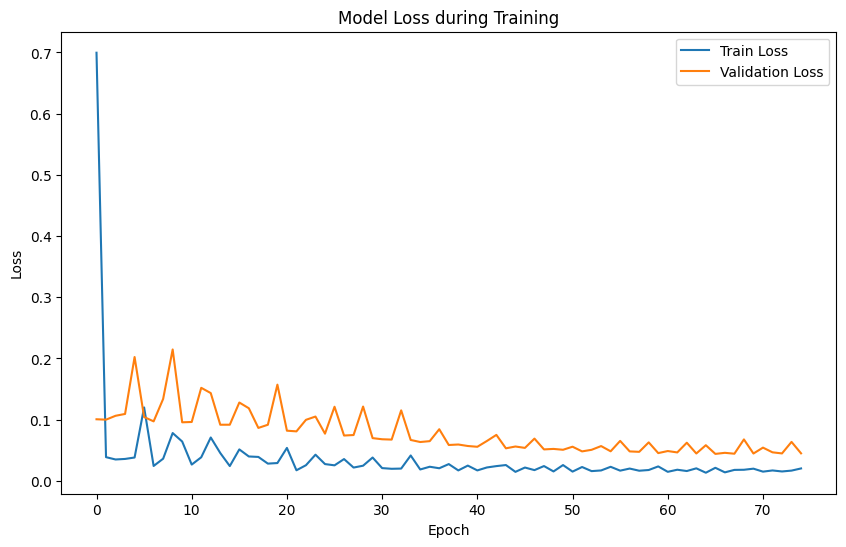

In [17]:
# Plot training and validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss during Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [18]:
# Let's reshape the predictions and Y_val to revert the scaling
# Reshape predictions to 2D
predictions_scaled_2d = predictions_scaled.reshape(-1, 1)

# Get the last timestep of X_val
X_val_last_timestep = X_val[:, -1, :]

# Replace the first column of X_val_last_timestep with the scaled predictions.
X_val_last_timestep[:, 0] = predictions_scaled_2d[:, 0]

# unscale the predictions
predictions_rescaled = scaler.inverse_transform(X_val_last_timestep)[:, 0]

# unscale the Y_val
Y_val_rescaled = scaler.inverse_transform(val.iloc[-len(predictions_scaled):, :].values)[:, 0]

# Calculate the error
GRU_mape_val = mean_absolute_percentage_error(Y_val_rescaled, predictions_rescaled)
GRU_rmse_val = np.sqrt(mean_squared_error(Y_val_rescaled, predictions_rescaled))
GRU_mae_val = mean_absolute_error(Y_val_rescaled, predictions_rescaled)

print(f'MAPE GRU VAL: {GRU_mape_val}')
print(f'RMSE GRU VAL: {GRU_rmse_val}')
print(f'MAE GRU VAL: {GRU_mae_val}')

MAPE GRU VAL: 0.6280711889266968
RMSE GRU VAL: 10557.943359375
MAE GRU VAL: 8163.44189453125


In [19]:
# Let's predict the test set using the best model
predictions_test_scaled = GRU_BEST_model.predict(X_test)

# Let's reshape the predictions and Y_val to revert the scaling
# Reshape predictions to 2D
predictions_test_scaled_2d = predictions_test_scaled.reshape(-1, 1)

# Get the last timestep of X_test
X_test_last_timestep = X_test[:, -1, :]

# Replace the first column of X_test_last_timestep with the scaled predictions.
X_test_last_timestep[:, 0] = predictions_test_scaled_2d[:, 0]

# unscale the predictions
predictions_test_rescaled = scaler.inverse_transform(X_test_last_timestep)[:, 0]

# Let's convert the predictions and Y_test to a dataframe usind the index from test
predictions_test_df = pd.DataFrame(predictions_test_rescaled, index=test.index[-len(predictions_test_rescaled):], columns=[target_variable])
predictions = predictions_test_df.copy()

# get the original Y_test values to calculate the error
Y_test_ori = df_adjusted[-len(predictions):][target_variable]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


In [20]:
# Calculate the error
mape_best_GRU = mean_absolute_percentage_error(Y_test_ori, predictions)
rmse_best_GRU = np.sqrt(mean_squared_error(Y_test_ori, predictions))
mae_best_GRU = mean_absolute_error(Y_test_ori, predictions)

print(f'MAPE best GRU: {mape_best_GRU}')
print(f'RMSE best GRU: {rmse_best_GRU}')
print(f'MAE best GRU: {mae_best_GRU}')

MAPE best GRU: 1.1414366960525513
RMSE best GRU: 18708.458984375
MAE best GRU: 15768.3916015625


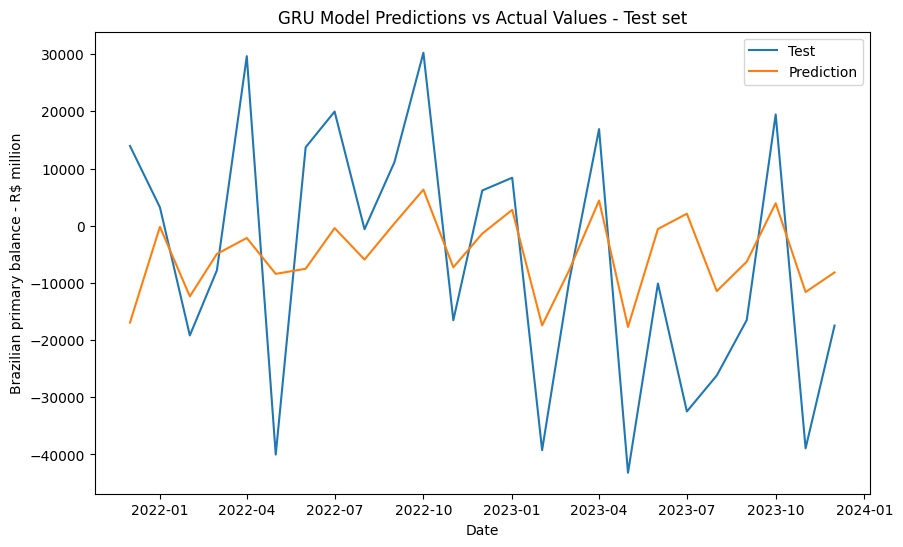

In [21]:
# Plot GRU best Model Predictions vs Actuals - Test set

# Convert Y_test_rescaled to a dataframe using the test index
Y_test_rescaled_df = pd.DataFrame(Y_test_ori, index=Y_test_ori.index)

# Change the column name to the target variable
Y_test_rescaled_df.columns = [target_variable]

# Plot the predictions vs the actual values using useful_functions
uf.plot_prediction_vs_test(
    target_variable, 
    Y_test_rescaled_df[target_variable],
    predictions,
    'GRU Model Predictions vs Actual Values - Test set')

### Feature importance

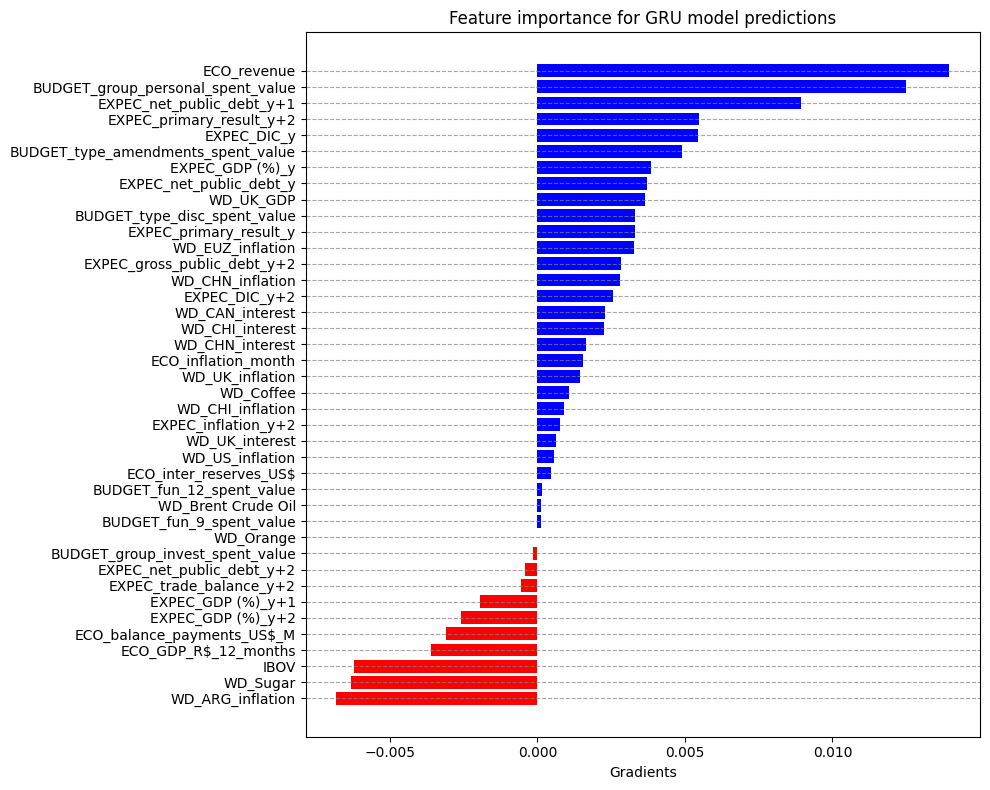

In [72]:
# To evaluate the importance of each feature in the model, we can use the gradients
# Function to return the gradients of the model
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads

# Apply the function
# Define some parameters
columns = df_raw.columns[1:] # Get the columns names
sequence_length = 12*2 # according to the sample size
id_ = 0 # First test sample index
test_date = test_raw.index # Get the index of the test set

# Get the gradients using the function
grad_imp = gradient_importance(X_test[id_], GRU_BEST_model)

# Pair the gradient importances with the column labels
grads_with_labels = list(zip(columns, grad_imp))
# Sort the pairs based on the gradient values
sorted_grads_with_labels = sorted(grads_with_labels, key=lambda x: x[1], reverse=False)
# Unzip the sorted pairs
sorted_columns, sorted_grad_imp = zip(*sorted_grads_with_labels)

# Plot the gradients
plt.figure(figsize=(10,8))
plt.subplots_adjust(left=0.3)
bar_colors = ['red' if x < 0 else 'blue' for x in sorted_grad_imp] # Red for negative gradients and blue for positive gradients
plt.barh(range(len(sorted_grad_imp)), sorted_grad_imp, color=bar_colors) # Horizontal bar plot
plt.yticks(range(len(sorted_columns)), sorted_columns, rotation=0)
plt.xlabel('Gradients')
plt.grid(True, linestyle='--', which='both', axis='y', color='gray', alpha=0.7) # grid horizontal lines
#plt.title(f"Variables importance for GRU model prediction for {pd.to_datetime(test_date[sequence_length + id_ - 1]).strftime('%b-%Y')}")
plt.title("Feature importance for GRU model predictions")
plt.tight_layout()
plt.show()

### Let's forecast

In [15]:
# Adjust the index to datetime format
df_adjusted.index = pd.to_datetime(df_adjusted.index)

# New list to store the forecasts
monthly_forecasts = []
number_of_months = 12

# Define a start date for the forecast
start_date = pd.Timestamp(year=2024, month=1, day=1)

# Given we want to forecast the next 12 months, we will loop 12 times
for i in range(number_of_months):  # For each month in the next year
    
    # Define a end date for the forecast
    end_date = start_date - pd.DateOffset(months=number_of_months+1)
    
    # Define a start date 12 months before the end date
    start_date_12_months_before = end_date - pd.DateOffset(months=number_of_months-1)
    
    # Subset the dataset to get the data for the last 12 months
    data_for_prediction = df_adjusted.loc[start_date_12_months_before:end_date]
    
    # Scale the data
    data_for_prediction_scaled = scaler.transform(data_for_prediction)
    data_for_prediction_scaled_df = pd.DataFrame(data_for_prediction_scaled, columns=df_adjusted.columns) # convert to dataframe
    
    # Include the index in the train and test sets
    data_for_prediction_scaled_df.index = data_for_prediction.index
    
    # Prepare the data for the model
    X_predict = np.array([data_for_prediction_scaled_df]) # convert to numpy array
    
    # Predict the next month
    future_prediction_scaled = GRU_BEST_model.predict(X_predict)
    
    # Reverse the scaling
    temp_array = np.zeros((1, len(df_adjusted.columns))) # Create an array of zeros
    temp_array[0, 0] = future_prediction_scaled[0, 0] # Store the prediction in the first column

    # rescale the prediction
    future_prediction_rescaled = scaler.inverse_transform(temp_array)[0, 0]

    ### Compute confidence intervals
    # Compute squared errors for each prediction point
    predictions_array = predictions.values.flatten() # Convert the predictions to a 1D array
    squared_errors = (Y_test_ori - predictions_array) ** 2
    rmse_errors = np.sqrt(squared_errors) # Take the square root of each squared error to get the RMSE for each point
    
    # Compute the standard error
    error_std = np.std(rmse_errors, axis=0)
    
    # Compute the lower and upper bounds
    lower_bound = future_prediction_rescaled - 1.96 * error_std # 95% confidence interval
    upper_bound = future_prediction_rescaled + 1.96 * error_std

    # Store the prediction and bounds
    monthly_forecasts.append((future_prediction_rescaled, lower_bound, upper_bound))
    
    # Change the start date to the next month
    start_date += pd.DateOffset(months=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


### Forecast

In [16]:
# Convert the forecasts to a DataFrame
# Get the last date of the test set
last_test_date = Y_test_rescaled_df.index[-1]
future_dates = pd.date_range(start=last_test_date + pd.DateOffset(months=1), periods=number_of_months, freq='MS')
monthly_forecasts_df = pd.DataFrame(monthly_forecasts, index=future_dates, columns=[target_variable, 'Lower Bound', 'Upper Bound'])

# Created a cumulative sum of the forecasts
monthly_forecasts_df['Cumulative Sum'] = monthly_forecasts_df[target_variable].cumsum()

In [17]:
monthly_forecasts_df

,ECO_fiscal_result_month,Lower Bound,Upper Bound,Cumulative Sum
2024-01-01,-8169.716273,-27902.967563,11563.535016,-8169.716273
2024-02-01,3792.187839,-15941.063450,23525.439128,-4377.528434
2024-03-01,-25971.625231,-45704.876520,-6238.373942,-30349.153665
2024-04-01,-9040.989528,-28774.240817,10692.261761,-39390.143194
2024-05-01,3374.899343,-16358.351946,23108.150632,-36015.243850
2024-06-01,-18734.711011,-38467.962300,998.540278,-54749.954861
2024-07-01,-5726.647259,-25459.898548,14006.604030,-60476.602120
2024-08-01,-6083.955572,-25817.206861,13649.295717,-66560.557693
2024-09-01,-12694.537720,-32427.789009,7038.713569,-79255.095413
2024-10-01,-5851.814628,-25585.065917,13881.436661,-85106.910041


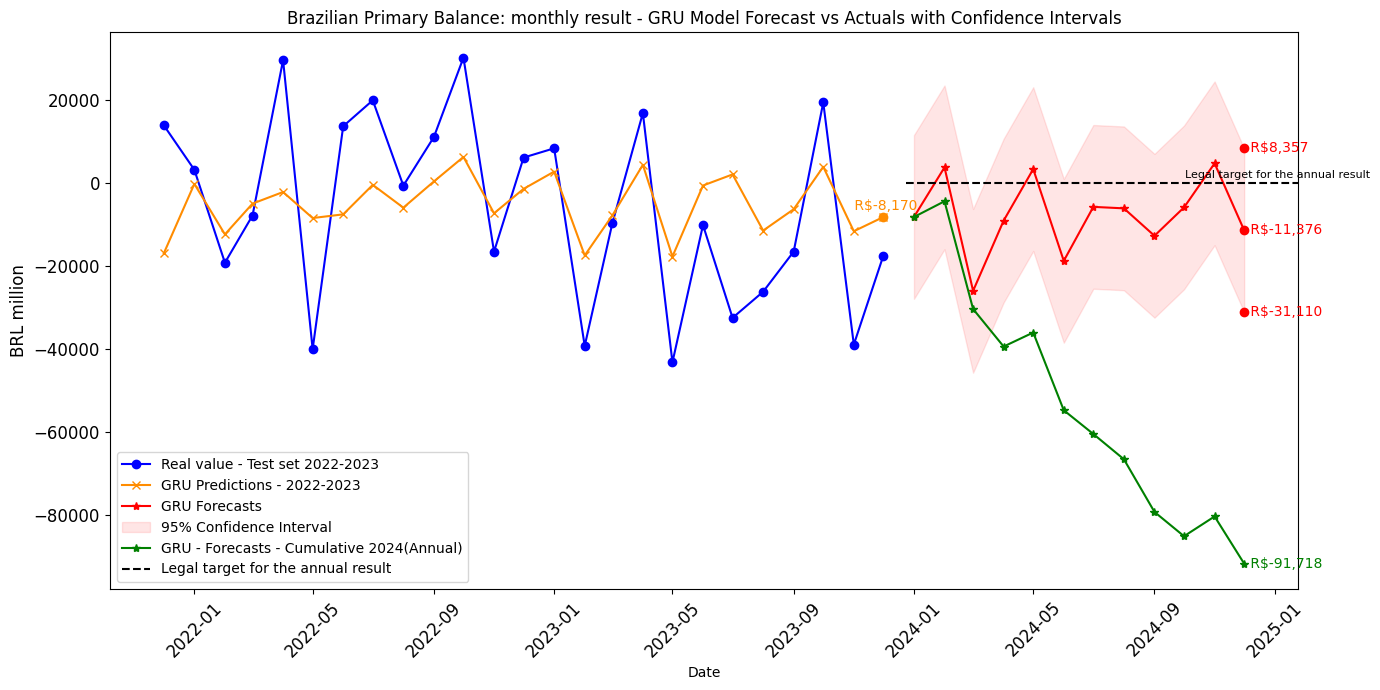

In [18]:
# Plot the actuals, test predictions, and future forecasts
plt.figure(figsize=(14, 7))
text_size = 10
# Includes actuals for the test set
plt.plot(Y_test_rescaled_df.index, Y_test_rescaled_df[target_variable], label='Real value - Test set 2022-2023', marker='o', color='blue')
# Includes predictions for the test set
plt.plot(predictions.index, predictions[target_variable], label='GRU Predictions - 2022-2023', marker='x', color='darkorange')
# Includes future forecasts with confidence intervals
plt.plot(monthly_forecasts_df.index, monthly_forecasts_df[target_variable], label='GRU Forecasts', marker='*', color='red')
# Includes confidence intervals
plt.fill_between(monthly_forecasts_df.index, 
                 monthly_forecasts_df['Lower Bound'], 
                 monthly_forecasts_df['Upper Bound'], 
                 color='red', alpha=0.1, label='95% Confidence Interval')
# Includes cumulative sum of the forecasts
plt.plot(monthly_forecasts_df.index, monthly_forecasts_df['Cumulative Sum'], label='GRU - Forecasts - Cumulative 2024(Annual)', marker='*', color='green')


# Annotate the last predicted observation
last_predicted_date = predictions.index[-1]
last_predicted_value = predictions[target_variable].iloc[-1]
plt.scatter(last_predicted_date, last_predicted_value, color='darkorange')  # Highlight the last point
# Annotate the last predicted observation
offset = 1000 #Offset the text so it doesn't overlap with the point
plt.text(last_predicted_date, last_predicted_value+offset, f' R${last_predicted_value:,.0f}', fontsize = text_size, color='darkorange', va='bottom', ha='center')

# Get the last forecast observation to annotate
last_forecast_date = monthly_forecasts_df.index[-1]
last_forecast_value = monthly_forecasts_df[target_variable].iloc[-1]
last_upper_bound_value = monthly_forecasts_df['Upper Bound'].iloc[-1]
last_lower_bound_value = monthly_forecasts_df['Lower Bound'].iloc[-1]
last_cumulative_sum = monthly_forecasts_df['Cumulative Sum'].iloc[-1]

# Highlight the last point
plt.scatter(last_forecast_date, last_forecast_value, color='red')
plt.scatter(last_forecast_date, last_upper_bound_value, color='red')
plt.scatter(last_forecast_date, last_lower_bound_value, color='red')
# Annotate the last forecast observation
horizontal_offset = timedelta(days=2) #Offset the text so it doesn't overlap with the point
plt.text(last_forecast_date+horizontal_offset, last_upper_bound_value, f' R${last_upper_bound_value:,.0f}', fontsize = text_size, color='red', va='center', ha='left') #upper bound
plt.text(last_forecast_date+horizontal_offset, last_lower_bound_value, f' R${last_lower_bound_value:,.0f}', fontsize = text_size, color='red', va='center', ha='left') #lower bound
plt.text(last_forecast_date+horizontal_offset, last_forecast_value, f' R${last_forecast_value:,.0f}', fontsize = text_size, color='red', va='center', ha='left') #forecast
plt.text(last_forecast_date+horizontal_offset, last_cumulative_sum, f' R${last_cumulative_sum:,.0f}', fontsize = text_size, color='green', va='center', ha='left') #cumulative sum

# Draw a dashed line to indicate the legal target
legal_target = 0
plt.axhline(y=legal_target, color='black', linestyle='--', xmin=0.67, xmax=1.05, label='Legal target for the annual result')

# Add a label for the legal target
plt.text(last_forecast_date-(30*horizontal_offset), 2000, 'Legal target for the annual result', fontsize = text_size-2, color='black', va='center', ha='left') # Legal target


plt.title('Brazilian Primary Balance: monthly result - GRU Model Forecast vs Actuals with Confidence Intervals')
plt.xlabel('Date', fontsize=text_size)
plt.ylabel('BRL million', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()
